# Tobacco trial classification
In this notebook we will try to classify 13M~ documents into 10 classes. 

The data is available in two different ways :
    - Textual data 
    - Images of the documents
    

### Necessary import (Make sure you can run this before running the script )

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
from keras.layers import Input, Dense,Activation,Convolution1D,Flatten,MaxPooling1D,Conv1D,LSTM,Dropout, Embedding
from keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
def confusion_matrix_NN(NN,x_test,y_test) :
        y_pred = NN.predict(np.array(x_test))
        y_test_class = np.argmax(y_test,axis=1)
        y_pred_class = np.argmax(y_pred,axis=1)
        cf = confusion_matrix(y_test_class,y_pred_class)
        print(cf)

#### Opening metadata

In [3]:
meta_data = pd.read_csv("data/Tobacco3482.csv")

# Here I'm extracting the label
labels = np.unique(meta_data["label"])

#### Opening data

In [4]:
x = []
y = []
label_classes = {}
i = 0
for l in labels :
    path = 'data/'+l+"/*.txt"
    print("Opening "+ l +" data")
    files=glob.glob(path)   
    for file in files:
        f=open(file, 'r')  
        x.append(f.read())
        y.append(l)
        f.close()
    label_classes[i] = l
    i+=1
print("Opened "+str(len(x))+" documents, "+str(len(np.unique(y)))+" different classes" )

Opening Advertisement data
Opening Email data
Opening Form data
Opening Letter data
Opening Memo data
Opening News data
Opening Note data
Opening Report data
Opening Resume data
Opening Scientific data
Opened 3482 documents, 10 different classes


# Statistical analysis of the data

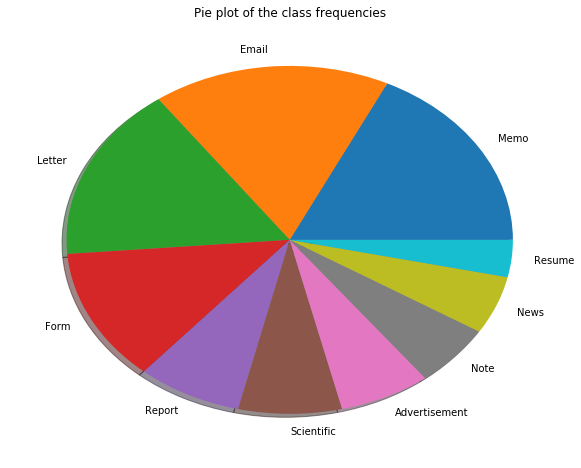

In [5]:
counts =meta_data["label"].value_counts()
plt.figure(1,figsize = (10,8))
plt.title("Pie plot of the class frequencies")
plt.pie(counts,labels = counts.index,shadow = True)
plt.show()

We can see that the classes are not very unbalanced even though 3 classes form half the data but given that they are Letter, Email and Memo, it's a normal behaviour given how the data were acquired

#### Pre-treatment of the data 

##### Tokenizing

Here we choose to tokenize the data in order to establish a baseline with a naive Bayes model.

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.1 , random_state = 42)

In [7]:
sentences = [text_to_word_sequence(s) for s in x]

vectorizer = CountVectorizer()
vectorizer.fit(x_train)

x_train_counts = vectorizer.transform(x_train)
x_test_counts = vectorizer.transform(x_test)

x_train_tfidf= TfidfTransformer().fit_transform(x_train_counts)
x_test_tfidf= TfidfTransformer().fit_transform(x_test_counts)


In [8]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train_tfidf,y_train)
print("Accuracy score : ")
print(clf.score(x_test_tfidf,y_test))
y_pred = clf.predict(x_test_tfidf)
print("Confusion matrix :")
print(confusion_matrix(y_pred,y_test))
print("Classification report :")
print(classification_report(y_pred,y_test))
print("Where classes are :")
for l in label_classes :
    print(str(l)+" : "+label_classes[l])

Accuracy score : 
0.48424068767908307
Confusion matrix :
[[ 4  0  0  0  0  0  0  0  0  0]
 [ 1 58  0  0  0  1  1  0  0  0]
 [ 4  0 17  0  0  3  5  0  0  1]
 [ 8  2  7 40  3  9  4  6  7 15]
 [16  6 24 20 47  2 10 12  0 13]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  1]]
Classification report :
             precision    recall  f1-score   support

          0       0.12      1.00      0.22         4
          1       0.88      0.95      0.91        61
          2       0.35      0.57      0.44        30
          3       0.67      0.40      0.50       101
          4       0.94      0.31      0.47       150
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
          7       0.00      0.00      0.00         0
          8       0.22      1.00      0.36         2
          9       0.03      1.00      0.06         1

avg

/home/robin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Neural network part

# tfidf into neural network part

In [9]:
# Neural Network for tfidf or word2vec
def model_creation(dim_data): 
    dim = dim_data

    NN1 = Sequential()
    LSTM(10,input_shape=(None,dim))
    NN1.add(Dropout(0.5))
    
    NN1.add(Dense(50,activation="relu"))
    NN1.add(Dropout(0.5))

    NN1.add(Dense(10, activation='softmax'))

    NN1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return NN1

In [10]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.1 , random_state = 42)

In [11]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
callbacks=[checkpointer]

NN = model_creation(75956)
hist = NN.fit(x_train_tfidf.toarray(),to_categorical(y_train),epochs=200,validation_split=0.1,batch_size = 512,callbacks=[checkpointer])
NN.load_weights('weights.hdf5')

Train on 2819 samples, validate on 314 samples
Epoch 1/200
2819/2819 [==============================] - 4s 2ms/step - loss: 2.2959 - acc: 0.2302 - val_loss: 2.2794 - val_acc: 0.4841

Epoch 00001: val_loss improved from inf to 2.27940, saving model to weights.hdf5
Epoch 2/200
2819/2819 [==============================] - 2s 685us/step - loss: 2.2579 - acc: 0.5066 - val_loss: 2.2406 - val_acc: 0.5350

Epoch 00002: val_loss improved from 2.27940 to 2.24064, saving model to weights.hdf5
Epoch 3/200
2819/2819 [==============================] - 2s 682us/step - loss: 2.2018 - acc: 0.6187 - val_loss: 2.1961 - val_acc: 0.6146

Epoch 00003: val_loss improved from 2.24064 to 2.19609, saving model to weights.hdf5
Epoch 4/200
2819/2819 [==============================] - 2s 679us/step - loss: 2.1412 - acc: 0.6566 - val_loss: 2.1473 - val_acc: 0.6146

Epoch 00004: val_loss improved from 2.19609 to 2.14725, saving model to weights.hdf5
Epoch 5/200
2819/2819 [==============================] - 2s 668us/s


Epoch 00037: val_loss improved from 0.95108 to 0.93762, saving model to weights.hdf5
Epoch 38/200
2819/2819 [==============================] - 2s 703us/step - loss: 0.4179 - acc: 0.9482 - val_loss: 0.9264 - val_acc: 0.7675

Epoch 00038: val_loss improved from 0.93762 to 0.92642, saving model to weights.hdf5
Epoch 39/200
2819/2819 [==============================] - 2s 681us/step - loss: 0.3948 - acc: 0.9539 - val_loss: 0.9150 - val_acc: 0.7643

Epoch 00039: val_loss improved from 0.92642 to 0.91503, saving model to weights.hdf5
Epoch 40/200
2819/2819 [==============================] - 2s 691us/step - loss: 0.3710 - acc: 0.9564 - val_loss: 0.9041 - val_acc: 0.7707

Epoch 00040: val_loss improved from 0.91503 to 0.90410, saving model to weights.hdf5
Epoch 41/200
2819/2819 [==============================] - 2s 679us/step - loss: 0.3583 - acc: 0.9599 - val_loss: 0.8928 - val_acc: 0.7771

Epoch 00041: val_loss improved from 0.90410 to 0.89284, saving model to weights.hdf5
Epoch 42/200
2819/

2819/2819 [==============================] - 2s 681us/step - loss: 0.1450 - acc: 0.9862 - val_loss: 0.7105 - val_acc: 0.8089

Epoch 00074: val_loss improved from 0.71216 to 0.71046, saving model to weights.hdf5
Epoch 75/200
2819/2819 [==============================] - 2s 677us/step - loss: 0.1450 - acc: 0.9858 - val_loss: 0.7075 - val_acc: 0.8089

Epoch 00075: val_loss improved from 0.71046 to 0.70755, saving model to weights.hdf5
Epoch 76/200
2819/2819 [==============================] - 2s 680us/step - loss: 0.1333 - acc: 0.9904 - val_loss: 0.7038 - val_acc: 0.8089

Epoch 00076: val_loss improved from 0.70755 to 0.70383, saving model to weights.hdf5
Epoch 77/200
2819/2819 [==============================] - 2s 689us/step - loss: 0.1360 - acc: 0.9890 - val_loss: 0.7005 - val_acc: 0.8057

Epoch 00077: val_loss improved from 0.70383 to 0.70053, saving model to weights.hdf5
Epoch 78/200
2819/2819 [==============================] - 2s 705us/step - loss: 0.1413 - acc: 0.9851 - val_loss: 0.69


Epoch 00110: val_loss improved from 0.64622 to 0.64580, saving model to weights.hdf5
Epoch 111/200
2819/2819 [==============================] - 2s 680us/step - loss: 0.0723 - acc: 0.9911 - val_loss: 0.6455 - val_acc: 0.8089

Epoch 00111: val_loss improved from 0.64580 to 0.64546, saving model to weights.hdf5
Epoch 112/200
2819/2819 [==============================] - 2s 676us/step - loss: 0.0740 - acc: 0.9926 - val_loss: 0.6446 - val_acc: 0.8121

Epoch 00112: val_loss improved from 0.64546 to 0.64462, saving model to weights.hdf5
Epoch 113/200
2819/2819 [==============================] - 2s 677us/step - loss: 0.0775 - acc: 0.9901 - val_loss: 0.6439 - val_acc: 0.8089

Epoch 00113: val_loss improved from 0.64462 to 0.64387, saving model to weights.hdf5
Epoch 114/200
2819/2819 [==============================] - 2s 681us/step - loss: 0.0749 - acc: 0.9922 - val_loss: 0.6430 - val_acc: 0.8057

Epoch 00114: val_loss improved from 0.64387 to 0.64301, saving model to weights.hdf5
Epoch 115/200


2819/2819 [==============================] - 2s 685us/step - loss: 0.0564 - acc: 0.9940 - val_loss: 0.6196 - val_acc: 0.8121

Epoch 00148: val_loss improved from 0.61980 to 0.61965, saving model to weights.hdf5
Epoch 149/200
2819/2819 [==============================] - 2s 683us/step - loss: 0.0517 - acc: 0.9933 - val_loss: 0.6195 - val_acc: 0.8121

Epoch 00149: val_loss improved from 0.61965 to 0.61954, saving model to weights.hdf5
Epoch 150/200
2819/2819 [==============================] - 2s 741us/step - loss: 0.0518 - acc: 0.9940 - val_loss: 0.6188 - val_acc: 0.8121

Epoch 00150: val_loss improved from 0.61954 to 0.61875, saving model to weights.hdf5
Epoch 151/200
2819/2819 [==============================] - 2s 749us/step - loss: 0.0524 - acc: 0.9950 - val_loss: 0.6187 - val_acc: 0.8121

Epoch 00151: val_loss improved from 0.61875 to 0.61867, saving model to weights.hdf5
Epoch 152/200
2819/2819 [==============================] - 2s 690us/step - loss: 0.0502 - acc: 0.9947 - val_loss: 

2819/2819 [==============================] - 2s 763us/step - loss: 0.0402 - acc: 0.9947 - val_loss: 0.6164 - val_acc: 0.8089

Epoch 00188: val_loss did not improve from 0.61399
Epoch 189/200
2819/2819 [==============================] - 2s 690us/step - loss: 0.0395 - acc: 0.9950 - val_loss: 0.6161 - val_acc: 0.8089

Epoch 00189: val_loss did not improve from 0.61399
Epoch 190/200
2819/2819 [==============================] - 2s 693us/step - loss: 0.0357 - acc: 0.9940 - val_loss: 0.6162 - val_acc: 0.8057

Epoch 00190: val_loss did not improve from 0.61399
Epoch 191/200
2819/2819 [==============================] - 2s 741us/step - loss: 0.0424 - acc: 0.9933 - val_loss: 0.6169 - val_acc: 0.8057

Epoch 00191: val_loss did not improve from 0.61399
Epoch 192/200
2819/2819 [==============================] - 2s 729us/step - loss: 0.0401 - acc: 0.9936 - val_loss: 0.6184 - val_acc: 0.7994

Epoch 00192: val_loss did not improve from 0.61399
Epoch 193/200
2819/2819 [==============================] - 

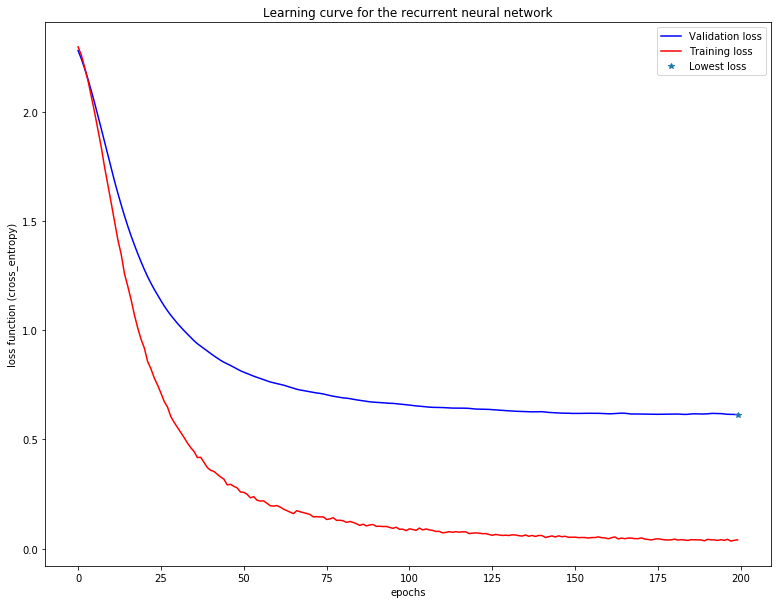

In [12]:
plt.figure("Learning curve",figsize=(13,10))
plt.plot(hist.history["val_loss"],"b")
plt.plot(hist.history["loss"],"r")
plt.plot(np.argmin(hist.history["val_loss"]),hist.history["val_loss"][np.argmin(hist.history["val_loss"])],"*")
plt.legend(("Validation loss","Training loss","Lowest loss"))
plt.title("Learning curve for the recurrent neural network")
plt.ylabel("loss function (cross_entropy)")
plt.xlabel("epochs")
plt.show()

In [13]:
print("Accuracy score :")
print(NN.evaluate(x_test_tfidf.toarray(),to_categorical(y_test))[1])

print("Confusion matrix :")
confusion_matrix_NN(NN,x_test_tfidf.toarray(),to_categorical(y_test))

print("Classification report :")
y_pred = NN.predict(np.array(x_test_tfidf.toarray()))
y_test_class = np.argmax(to_categorical(y_test),axis=1)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(y_pred_class,y_test_class))

print("Where classes are :")
for l in label_classes :
    print(str(l)+" : "+label_classes[l])

Accuracy score :
349/349 [==============================] - 0s 579us/step
0.8366762165695344
Confusion matrix :
[[23  0  4  1  0  0  4  1  0  0]
 [ 0 66  0  0  0  0  0  0  0  0]
 [ 1  0 39  3  2  0  1  1  0  1]
 [ 0  1  1 53  4  0  0  1  0  0]
 [ 0  1  2  1 46  0  0  0  0  0]
 [ 0  0  3  0  0 12  0  0  0  0]
 [ 0  0  3  1  2  0 14  0  0  0]
 [ 0  0  1  5  0  0  0 10  0  2]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  1  0  4  1  1  2  1 20]]
Classification report :
             precision    recall  f1-score   support

          0       0.70      0.96      0.81        24
          1       1.00      0.97      0.99        68
          2       0.81      0.72      0.76        54
          3       0.88      0.83      0.85        64
          4       0.92      0.79      0.85        58
          5       0.80      0.92      0.86        13
          6       0.70      0.70      0.70        20
          7       0.56      0.67      0.61        15
          8       1.00      0.90      0.95        10
  

# Conclusion and comparaison 

In the previous part, we compared two approaches for the resolution of this problem. We established a baseline which was training a naive bayes model on the tfidf transformed data. The second approach was to use a recurrent neural network to classify the same data. 
As we could observe, the bayesian model established a baseline at ~50% accuracy. We succedeed in reaching a 82% accuracy in test with the neural network. 
Concerning the confusion matrix of the 2 models, the bayesian one is really unbalanced since many classes are mistaken for memo. This might be caused by the over representation of the memo class. 
However we can see that the confusion matrix of the neural network is balanced.